In [2]:
# Load library
import cv2
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda, Dot, Conv2D, MaxPool2D, Flatten
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print("Tensorflow version: ", tf.__version__)
print(tf.test.gpu_device_name())
# Your expected output will be '/device:GPU:0'


Tensorflow version:  2.10.0
/device:GPU:0


In [6]:
# Google drive implementation
# from google.colab import drive
# drive.mount('/content/gdrive')

import os
# os.chdir('/content/gdrive/My Drive/VSE/person')
# using local data folder
os.chdir('./')
# windows
!dir

 Volume in drive D is Data
 Volume Serial Number is F0A3-4DB8

 Directory of D:\ISS Masters\Vision System Project\IntelligentSensingSystemProject

03/02/2023  10:41 AM    <DIR>          .
03/02/2023  10:41 AM    <DIR>          ..
03/02/2023  10:24 AM             1,830 .gitignore
03/02/2023  10:35 AM    <DIR>          .idea
03/02/2023  10:30 AM    <DIR>          .ipynb_checkpoints
03/02/2023  10:13 AM    <DIR>          data
03/02/2023  10:03 AM    <DIR>          ISS-Templates
03/02/2023  09:54 AM             1,078 LICENSE
03/02/2023  09:54 AM                33 README.md
03/02/2023  10:41 AM         1,072,042 SiameseNetworkNotebook.ipynb
               4 File(s)      1,074,983 bytes
               6 Dir(s)  959,411,544,064 bytes free


In [8]:
# # Define the configuration of HoG feature extraction
#
# # Resize the input image to a fixed resolution for feature extraction
# IMG_HEIGHT = 128
# IMG_WIDTH = 64
#
# # Block size, Cell size, Stride size, Number of bins as defined in HoG.
# blockSize = (16, 16)
# blockStride = (8, 8)
# cellSize = (8, 8)
# nbins = 9
#
# # Step 1: Load images and resize images
# test_image1 = cv2.imread('yao2.jpg')
# test_image2 = cv2.imread('yao1.jpg')
#
# test_image1 = cv2.resize(test_image1, (IMG_WIDTH, IMG_HEIGHT))
# test_image2 = cv2.resize(test_image2, (IMG_WIDTH, IMG_HEIGHT))
#
# # Step 2: Extract HoG features
# hog = cv2.HOGDescriptor((IMG_WIDTH, IMG_HEIGHT), blockSize, blockStride, cellSize, nbins)
# test_image1_hog = hog.compute(test_image1)
# test_image2_hog = hog.compute(test_image2)
#
# # Step 3: Normalize the HoG features and calculate their cosine similarity distance
# test_image1_hog = test_image1_hog/np.linalg.norm(test_image1_hog)
# test_image2_hog = test_image2_hog/np.linalg.norm(test_image2_hog)
#
# sims = np.inner(np.transpose(test_image1_hog), np.transpose(test_image2_hog))
# print('The cosine similarity of two images is %.4f' % sims)
#
# # Display the input images
# plt.figure()
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.subplot(1, 2, 2)
# plt.imshow(cv2.cvtColor(test_image2, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.show()


Read from LOCAL data folder

In [10]:
# Define the path for the downloaded images
PATH = "data/"
dirs = sorted(os.listdir(PATH))

# Build two dictionaries
name_to_classid = {d: i for i, d in enumerate(dirs)}
classid_to_name = {v: k for k, v in name_to_classid.items()}

# read all directories
img_paths = {c: [PATH + subfolder + "/" + img
                 for img in sorted(os.listdir(PATH + subfolder))]
             for subfolder, c in name_to_classid.items()}

# retrieve all images
all_images_path = []
for img_list in img_paths.values():
    all_images_path += img_list

# map to integers
path_to_imageid = {v: k for k, v in enumerate(all_images_path)}
imageid_to_path = {v: k for k, v in path_to_imageid.items()}

# build mappings between images and class
classid_to_imageid = {k: [path_to_imageid[path] for path in v] for k, v in img_paths.items()}
imageid_to_classid = {v: c for c,imgs in classid_to_imageid.items() for v in imgs}

print("Total number of classes in workshop: ", len(classid_to_imageid))
print("Total number of images (files) in workshop: ", len(imageid_to_classid))

Total number of classes in workshop:  6
Total number of images (files) in workshop:  221


# Prepare dataset to train a deep learning model for person verification

- Build paris of positive and negative training images
- Split dataset into train and test subsets for model training


In [39]:
# build pairs of positive image ids for a given classid
def build_pos_pairs_imageid(classid, max_num=5):
    imgs = classid_to_imageid[classid]
    if len(imgs) == 1:
        return []
    pos_pairs = [(imgs[i], imgs[j])
                 for i in range(len(imgs))
                 for j in range(i + 1, len(imgs))]
    random.shuffle(pos_pairs)
    return pos_pairs[:max_num]

# build pairs of negative image ids for a given classid
# def build_neg_pairs_imageid(classid, classes, max_num=5):
#     imgs = classid_to_imageid[classid]
#     neg_classes_imageid = random.sample(classes, max_num+1)
#     print(neg_classes_imageid)
#     if classid in neg_classes_imageid:
#         neg_classes_imageid.remove(classid)
#     neg_pairs = []
#     for id2 in range(max_num):
#         img1 = imgs[random.randint(0,len(imgs)-1)]
#         imgs2 = classid_to_imageid[neg_classes_imageid[id2]]
#         img2 = imgs2[random.randint(0,len(imgs2)-1)]
#         neg_pairs += [(img1, img2)]
#     return neg_pairs


def build_neg_pairs_imageid(classid, classes, max_num=5):
    imgs = classid_to_imageid[classid]
    neg_classes_imageid = random.sample(classes, len(classes))
    if classid in neg_classes_imageid:
        neg_classes_imageid.remove(classid)
    neg_pairs = []
    for id2 in range(len(neg_classes_imageid)):
        img1 = imgs[random.randint(0,len(imgs)-1)]
        imgs2 = classid_to_imageid[id2]
        img2 = imgs2[random.randint(0,len(imgs2)-1)]
        neg_pairs += [(img1, img2)]
    return neg_pairs

def open_all_images(id_to_path):
    all_imgs = []
    for path in id_to_path.values():
        temp = cv2.imread(path) / 255
        temp = cv2.resize(temp, (100, 100)).astype('float32') # convert image into float32    
        all_imgs += [np.expand_dims(temp,0)]
    return np.vstack(all_imgs)

def build_train_test_data(num_classes, split=0.8):
    listX1 = []
    listX2 = []
    listY = []
    split = int(num_classes * split)
    
    # train
    for id in range(split):
        pos = build_pos_pairs_imageid(id)
        neg = build_neg_pairs_imageid(id, list(range(split)))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [0]
    perm = np.random.permutation(len(listX1))
    X1_ids_train = np.array(listX1)[perm]
    X2_ids_train = np.array(listX2)[perm]
    Y_ids_train = np.array(listY)[perm]
    
    listX1 = []
    listX2 = []
    listY = []
    
    # test
    for id in range(split, num_classes):
        pos = build_pos_pairs_imageid(id)
        neg = build_neg_pairs_imageid(id, list(range(split, num_classes)))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [0]
    X1_ids_test = np.array(listX1)
    X2_ids_test = np.array(listX2)
    Y_ids_test = np.array(listY)
    return (X1_ids_train, X2_ids_train, Y_ids_train.astype('float32'), X1_ids_test, X2_ids_test, Y_ids_test.astype('float32'))

# Build a custom dataset generator, https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, X1, X2, Y, batch_size, all_imgs):
        
        self.batch_size = batch_size
        self.X1 = X1
        self.X2 = X2
        self.Y = Y
        self.imgs = all_imgs
        self.num_samples = Y.shape[0]
        self.indexes = np.arange(self.num_samples)
    
    def on_epoch_end(self):
        np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        imgs1 = self.X1[indexes]
        imgs2 = self.X2[indexes]

        return [self.imgs[imgs1], self.imgs[imgs2]], self.Y[indexes]
   
    def __len__(self):
        return int(np.floor(self.num_samples / self.batch_size))


# train pairs (32,) (32,) (32,) # test pairs (12,) (12,) (12,)
Total images:  (221, 100, 100, 3)


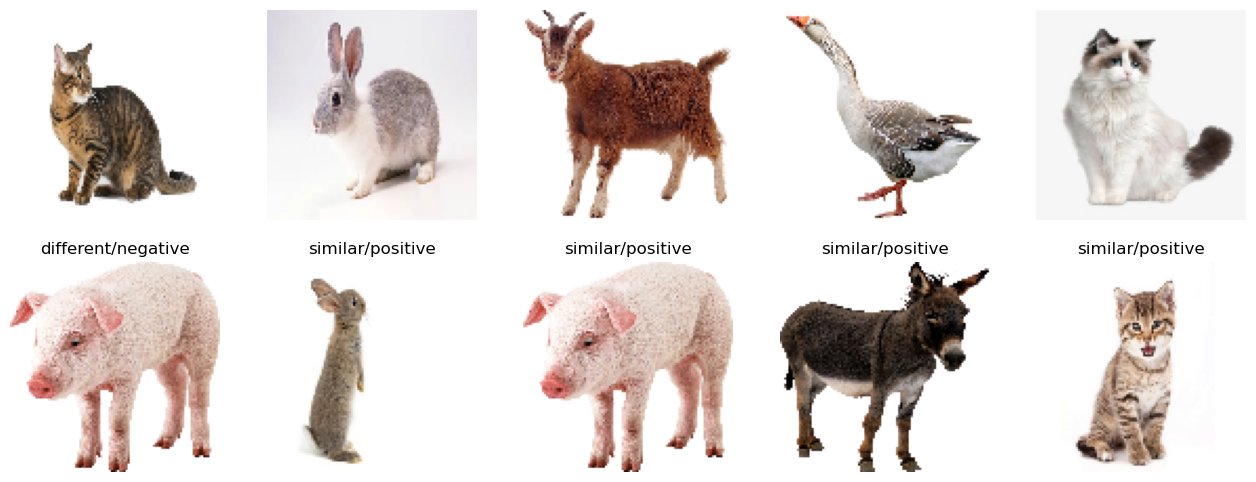

In [40]:
# Generate training imageid index and test imageid index
num_classes = len(name_to_classid) # Total number of persons used in this workshop
X1_ids_train, X2_ids_train, train_Y, X1_ids_test, X2_ids_test, test_Y = build_train_test_data(num_classes) # remove this -1 once we have more than 6 classes
print('# train pairs', X1_ids_train.shape, X2_ids_train.shape, train_Y.shape, '# test pairs', X1_ids_test.shape, X2_ids_test.shape, test_Y.shape)

# Open all images
all_imgs = open_all_images(imageid_to_path)
print('Total images: ', all_imgs.shape)

# Build a dataloader
myGenerator = CustomDataGen(X1_ids_train, X2_ids_train, train_Y, 6, all_imgs)

# Display a few pairs of training images
[x1, x2], y = myGenerator[0]

plt.figure(figsize=(16, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(x1[i], cv2.COLOR_BGR2RGB)) # Convert image color format, as Opencv load image in RGR format
    plt.axis('off')
for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(cv2.cvtColor(x2[i], cv2.COLOR_BGR2RGB))
    if y[i]==1.0:
        plt.title("similar/positive")
    else:
        plt.title("different/negative")
    plt.axis('off')
plt.show()

# Prepare test image subset
test_X1 = all_imgs[X1_ids_test]
test_X2 = all_imgs[X2_ids_test]

# Exercise 2: Design and train a person verification model

Objectives: Build a convolutional model. Warning: Large convolutions on high dimensional images can be very slow on CPUs.

In [41]:
# Define a shared base CNN model
inp = Input((100, 100, 3), dtype='float32')
x = Conv2D(16, 3, activation="relu", padding="same")(inp)
x = Conv2D(16, 3, activation="relu", padding="same")(x)
x = MaxPool2D((2,2))(x)
x = Flatten()(x)
x = Dense(50)(x)
shared_conv = Model(inputs=inp, outputs=x)

print('Input: ', all_imgs.shape)
print('Output: ', shared_conv.predict(all_imgs).shape)

shared_conv.summary()


Input:  (221, 100, 100, 3)
7/7 [==============================] - 8s 21ms/step
Output:  (221, 50)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 40000)             0         
                                                                 
 dense (Dense)               

In [42]:
# Define Euclidean distance function

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

# create customized layer
class CustomizedEuclideanDistanceLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        super().build(input_shape)
    
    def call(self, inputs):
        return euclidean_distance(inputs)

euclidean_dis_layer_lambda = Lambda(euclidean_distance, name="outpur_layer", output_shape=eucl_dist_output_shape)


In [43]:
# Define Siamese network model

# create the left input and point to the base network
input_1 = Input((100, 100, 3), dtype='float32', name="left_input")
embedding1 = shared_conv(input_1)

# create the right input and point to the base network
input_2 = Input((100, 100, 3), dtype='float32', name="right_input")
embedding2 = shared_conv(input_2)

# measure the similarity of the two vector outputs
output = euclidean_dis_layer_lambda([embedding1, embedding2])

# specify the inputs and output of the model
model = Model([input_1, input_2], output)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 right_input (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 50)           2002818     ['left_input[0][0]',             
                                                                  'right_input[0][0]']      

In [44]:
# Define the loss function

def contrastive_loss(y_true, y_pred, margin=0.5):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square) 

model.compile(loss=contrastive_loss, optimizer='adam')

NUM_EPOCH = 40
hist = model.fit(myGenerator, steps_per_epoch=train_Y.shape[0] // 32, epochs=NUM_EPOCH, validation_data=([test_X1, test_X2], test_Y), verbose=1)


Epoch 1/40
1/1 [==============================] - 3s 3s/step - loss: 0.8428 - val_loss: 8.5765
Epoch 2/40
1/1 [==============================] - 0s 63ms/step - loss: 13.1531 - val_loss: 5.7317
Epoch 3/40
1/1 [==============================] - 0s 47ms/step - loss: 2.6243 - val_loss: 9.2097
Epoch 4/40
1/1 [==============================] - 0s 53ms/step - loss: 133.5744 - val_loss: 3.6201
Epoch 5/40
1/1 [==============================] - 0s 63ms/step - loss: 1.6670 - val_loss: 2.1859
Epoch 6/40
1/1 [==============================] - 0s 53ms/step - loss: 0.3477 - val_loss: 2.1915
Epoch 7/40
1/1 [==============================] - 0s 47ms/step - loss: 7.0592 - val_loss: 2.0392
Epoch 8/40
1/1 [==============================] - 0s 63ms/step - loss: 9.4439 - val_loss: 1.5526
Epoch 9/40
1/1 [==============================] - 0s 38ms/step - loss: 8.7933 - val_loss: 0.9904
Epoch 10/40
1/1 [==============================] - 0s 51ms/step - loss: 4.8256 - val_loss: 0.6573
Epoch 11/40
1/1 [===========

1/1 [==============================] - 0s 464ms/step
Different person, distance (Siamese network output) is  [[0.13137506]]


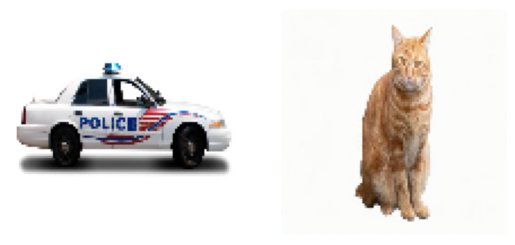

In [47]:
# Use the test pairs to see the model prediction result
test_index = 11
test_image1 = all_imgs[X1_ids_test[test_index]]
test_image2 = all_imgs[X2_ids_test[test_index]]

y_pred = model.predict([np.expand_dims(test_image1, 0), np.expand_dims(test_image2, 0)])
if (test_Y[test_index] == 1):
    print('Same person, distance (Siamese network output) is ', y_pred)
else:
    print('Different person, distance (Siamese network output) is ', y_pred)

# Plot the test pairs images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(test_image2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 31ms/step
The dissimlarity of two images is 0.0242


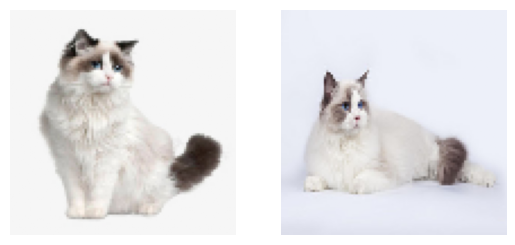

In [49]:

# Step 1: Load images and resize images
test_image1 = cv2.imread('./test/cat006.jpg')/255
test_image2 = cv2.imread('./test/cat018.jpg')/255
#test_image2 = cv2.imread('bill1.jpg')

# Load image, change the shape of the image
test_image1 = cv2.resize(test_image1, (100, 100)).astype('float32')
test_image2 = cv2.resize(test_image2, (100, 100)).astype('float32')

# Step 2: Extract features using the pre-trained siamese model
# Note: need to expand the input image to be 4D to fit into the model
test_image1_coeff = shared_conv.predict(np.expand_dims(test_image1, 0))
test_image2_coeff = shared_conv.predict(np.expand_dims(test_image2, 0))

# Calculate euclidean distance between embeded features
dist = np.linalg.norm(test_image1_coeff - test_image2_coeff)
print('The dissimlarity of two images is %.4f' % dist)

# Plot the two given images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(test_image2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


# Exercise 3: Apply the person verification model to find the most similar image given the query image


Query person name: Cat


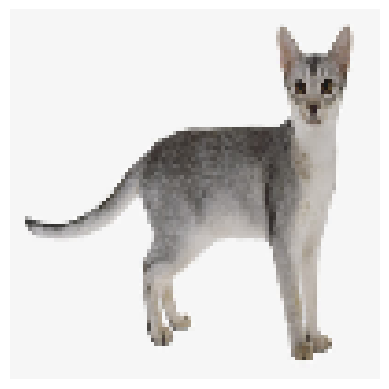

7/7 [==============================] - 0s 40ms/step
Person name:  Cat Distance:  0.0


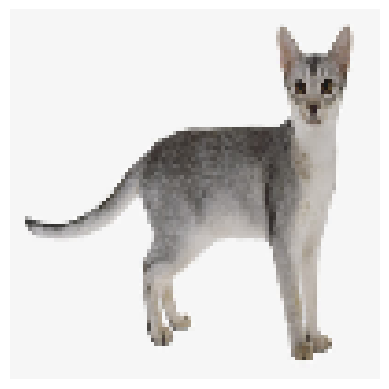

Person name:  Farm Distance:  0.014311299695618925


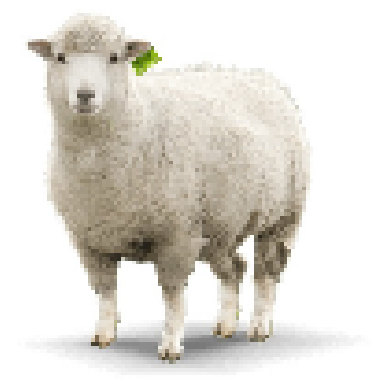

Person name:  Veg Distance:  0.0143181975302545


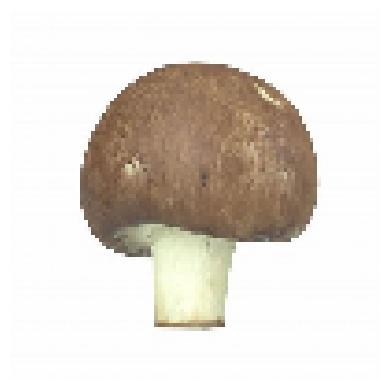

In [50]:
# - Randomly select a query image, apply the the pre-trained siamese model to find similar images from the data `all_imgs`
# - Display the query image, top three similar images, and their respective dissimlarity score.
# Define functions used to pickup the smallest distance photo and display

def smallest_distance(x, emb, topn=3):
    from scipy.spatial.distance import cdist
    dist = cdist(x, emb) 
    ids = np.argsort(dist)#[::-1]
    return [(id, dist[0,id]) for id in ids[0,:topn]]

def display(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Choose a random test photo
class_id = 0
query_id = random.choice(classid_to_imageid[class_id])
print("Query person name:", classid_to_name[class_id])
display(all_imgs[query_id])

# Extract features for all images
emb = shared_conv.predict(all_imgs)

for result_id, dist in smallest_distance(emb[query_id:query_id+1,:], emb):
    class_name = classid_to_name.get(imageid_to_classid.get(result_id))
    print('Person name: ', class_name, 'Distance: ', dist)    
    display(all_imgs[result_id])
